<a href="https://colab.research.google.com/github/ywang1110/Modeling_Triboelectric_Performance/blob/main/Absolute_Humidity___PP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from sklearn.feature_selection import f_regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prepare dataset

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/My Drive/0 Sarah PP/0 Data/Humidity/Sarah_PP.xlsx')
df.head()

,Unnamed: 0,Label,ChargeDensity(µC/m2) j,Thickness(um),solidity,diameter(um),Interface(mm),Tem,Humidity (%),Force (N)
0,0,S-1,13.233000,524.766667,0.088333,6.184,1.123,25.133333,47.633333,36.133333
1,1,S-11,19.201667,360.533333,0.127333,3.296,0.765,24.766667,50.033333,36.433333
2,2,S-13,10.868000,537.533333,0.087667,6.238,1.429,25.733333,45.600000,36.766667
3,3,S-14,19.316333,404.166667,0.118667,3.580,0.752,24.600000,49.466667,35.800000
4,4,S-15,26.553667,316.933333,0.148667,2.554,0.857,25.600000,45.033333,36.100000


In [4]:
df['Absolute humidity (g/m3)'] = (6.112*2.71828**((17.67*df['Tem'])/(df['Tem']+243.5))*df['Humidity (%)']*2.1674)/(273.15+df['Tem'])
df.head()

,Unnamed: 0,Label,ChargeDensity(µC/m2) j,Thickness(um),solidity,diameter(um),Interface(mm),Tem,Humidity (%),Force (N),Absolute humidity (g/m3)
0,0,S-1,13.233000,524.766667,0.088333,6.184,1.123,25.133333,47.633333,36.133333,11.050496
1,1,S-11,19.201667,360.533333,0.127333,3.296,0.765,24.766667,50.033333,36.433333,11.369909
2,2,S-13,10.868000,537.533333,0.087667,6.238,1.429,25.733333,45.600000,36.766667,10.941194
3,3,S-14,19.316333,404.166667,0.118667,3.580,0.752,24.600000,49.466667,35.800000,11.135841
4,4,S-15,26.553667,316.933333,0.148667,2.554,0.857,25.600000,45.033333,36.100000,10.724792


In [5]:
df.shape

(17, 11)

## Unit conversion

In [6]:
data = pd.DataFrame()
data['ChargeDensity(C/m2)']=df['ChargeDensity(µC/m2) j']*pow(10,-6)
data['thickness(m)']=df['Thickness(um)']*pow(10,-6)
data['solidity'] = df['solidity']
data['diameter(m)'] = df['diameter(um)']*pow(10,-6)
data['Interface(m)']=df['Interface(mm)']*pow(10, -3)
data[['Tem (°C)', 'Absolute humidity (g/m3)', 'Force (N)']]=df[['Tem', 'Absolute humidity (g/m3)', 'Force (N)']]

data.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Absolute humidity (g/m3),Force (N)
0,0.000013,0.000525,0.088333,0.000006,0.001123,25.133333,11.050496,36.133333
1,0.000019,0.000361,0.127333,0.000003,0.000765,24.766667,11.369909,36.433333
2,0.000011,0.000538,0.087667,0.000006,0.001429,25.733333,10.941194,36.766667
3,0.000019,0.000404,0.118667,0.000004,0.000752,24.600000,11.135841,35.800000
4,0.000027,0.000317,0.148667,0.000003,0.000857,25.600000,10.724792,36.100000


In [7]:
data.shape

(17, 8)

# Train test split

In [8]:
random_state=15

kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
train_indexs = []
test_indexs = []
for train_index, test_index in kf.split(data):
    train_indexs.append(train_index)
    test_indexs.append(test_index)
index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
index

,train_index,test_index
0,"[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]","[2, 3, 4, 16]"
1,"[0, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16]","[1, 9, 10, 11]"
2,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16]","[6, 13, 14]"
3,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16]","[0, 7, 15]"
4,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 16]","[5, 8, 12]"


In [9]:
n_fold=4

In [10]:
train_index = index.iloc[n_fold,0]
test_index = index.iloc[n_fold,1]
train, test = data.iloc[train_index], data.iloc[test_index]
train.shape

(14, 8)

In [11]:
train.shape

(14, 8)

In [12]:
test.shape

(3, 8)

In [13]:
"""
train.to_csv('train.csv')
test.to_csv('test.csv')
"""


"\ntrain.to_csv('train.csv')\ntest.to_csv('test.csv')\n"

In [14]:
"""
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
"""

"\ntrain = pd.read_csv('train.csv')\ntest=pd.read_csv('test.csv')\n"

In [15]:
train.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Absolute humidity (g/m3),Force (N)
0,0.000013,0.000525,0.088333,0.000006,0.001123,25.133333,11.050496,36.133333
1,0.000019,0.000361,0.127333,0.000003,0.000765,24.766667,11.369909,36.433333
2,0.000011,0.000538,0.087667,0.000006,0.001429,25.733333,10.941194,36.766667
3,0.000019,0.000404,0.118667,0.000004,0.000752,24.600000,11.135841,35.800000
4,0.000027,0.000317,0.148667,0.000003,0.000857,25.600000,10.724792,36.100000


In [16]:
# Train the model
x=train['thickness(m)'].to_numpy()
y=train['solidity'].to_numpy()
z=train['diameter(m)'].to_numpy()
u=train['Interface(m)'].to_numpy()
h=train['Absolute humidity (g/m3)'].to_numpy()
j=train['ChargeDensity(C/m2)'].to_numpy()
def func(X,a, w, c, m, n, p):
  x,y,z,u,h = X
  return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

# lm
popt_lm,pcov = curve_fit(func,(x,y,z,u,h),j, method='lm', maxfev = 50000)
y_model_lm = func((x,y,z,u, h),popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5]) 
MSE_lm = mean_squared_error(j, y_model_lm)
MAE_lm = mean_absolute_error(j, y_model_lm)
lm_result="lm Method | MSE = {:.2E}| MAE = {:.2E}| a = {:.2E}, w = {:.2E}, c = {:.2E},m = {:.2E}, n = {:.2E}, p = {:.2E}".format(MSE_lm,MAE_lm,popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5])
lm_result  

'lm Method | MSE = 1.16E-12| MAE = 9.47E-07| a = -9.12E-02, w = -1.26E-03, c = 2.00E+00,m = 1.00E+00, n = 1.00E+00, p = 1.00E+00'

In [17]:
# initial guesses for a,b,c,m,n,p:
p0 = 1E-6 , 0 ,1. , 1. , 1., 1.

In [18]:
  # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=50000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=50000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  print(trf_result)
  print(dog_result)

trf Method is the best method
trf Method | MSE = 1.16E-12| MAE = 9.49E-07| a = 5.092279015736309e-05, w = 6.036928794741998e-07, c = 2.1084049535056963,m = 1.010734705502889, n = 1.0205646878394428, p = 1.0090335394575178
dog Method | MSE = 1.14E-11| MAE = 3.04E-06| a = 9.839318093690653e-06, w = 6.74768697103483e-07, c = 1.458251953125,m = 1.00000268084585, n = 1.000005087872208, p = 1.0000021586196142


In [19]:
  # Validate (when trf is best)

  data_val = pd.concat([train, test])
  data_val.head()
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Absolute humidity (g/m3)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()

  


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  data_val['ratio(%)'] = (data_val['Predicted(C/m2)'] -data_val['ChargeDensity(C/m2)'])/data_val['ChargeDensity(C/m2)']*100
  data_val['ChargeDensity(uC/m2)'] = data_val['ChargeDensity(C/m2)']*pow(10,6)
  data_val['Predicted(uC/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)*pow(10,6)
  data_val['ratio_2(%)'] = (data_val['Predicted(uC/m2)']-data_val['ChargeDensity(uC/m2)'])/data_val['ChargeDensity(uC/m2)']*100
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])
  
  print('MAPE= {:.2f}'.format(mape))
  print('Train_MAPE = {:.2f}'.format(mape_train))
  print('test_MAPE = {:.2f}'.format(mape_test))

MAPE= 7.35
Train_MAPE = 6.81
test_MAPE = 9.88


In [20]:
data_val.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Absolute humidity (g/m3),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%)
0,0.000013,0.000525,0.088333,0.000006,0.001123,25.133333,11.050496,36.133333,0.000012,-9.707893,13.233000,11.948355,-9.707893
1,0.000019,0.000361,0.127333,0.000003,0.000765,24.766667,11.369909,36.433333,0.000021,7.937280,19.201667,20.725757,7.937280
2,0.000011,0.000538,0.087667,0.000006,0.001429,25.733333,10.941194,36.766667,0.000012,6.225117,10.868000,11.544546,6.225117
3,0.000019,0.000404,0.118667,0.000004,0.000752,24.600000,11.135841,35.800000,0.000019,-1.079590,19.316333,19.107796,-1.079590
4,0.000027,0.000317,0.148667,0.000003,0.000857,25.600000,10.724792,36.100000,0.000026,-3.943474,26.553667,25.506530,-3.943474


In [21]:
data_val.describe()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Absolute humidity (g/m3),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%)
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.000016,0.000491,0.105294,0.000004,0.001238,25.337255,11.097014,36.482353,0.000016,0.252217,16.269294,16.252157,0.252217
std,0.000005,0.000101,0.021843,0.000002,0.000468,0.521600,0.428877,0.564840,0.000005,9.071334,4.812006,4.726503,9.071334
min,0.000007,0.000317,0.059667,0.000002,0.000752,24.600000,9.849331,35.800000,0.000007,-19.698191,6.776333,6.866072,-19.698191
25%,0.000013,0.000438,0.088667,0.000003,0.000886,25.000000,10.902720,36.100000,0.000013,-4.952624,13.233000,12.941748,-4.952624
50%,0.000017,0.000493,0.109333,0.000004,0.001180,25.400000,11.081651,36.433333,0.000017,0.095709,17.164667,17.354781,0.095709
75%,0.000019,0.000525,0.120333,0.000005,0.001369,25.733333,11.428495,36.766667,0.000019,6.586437,19.316333,18.686844,6.586437
max,0.000027,0.000743,0.148667,0.000010,0.002673,26.166667,11.663183,38.100000,0.000026,13.778790,26.553667,25.506530,13.778790


In [22]:
data_val.to_csv('data_val_PP.csv')

# Simulation

In [23]:
label = 1
set_thickness = data.loc[label]['thickness(m)']
set_solidity = data.loc[label]['solidity']
set_diameter = data.loc[label]['diameter(m)']
set_u = data.loc[label]['Interface(m)']
set_h = data.loc[label]['Absolute humidity (g/m3)']
print('set_thickness = {:.3E}\nset_solidity = {:.3f}\nset_diameter = {:.2E} \nset_u= {:.3f} \nset_h= {:.1f}'.format(set_thickness, set_solidity, set_diameter, set_u, set_h))

set_j = data.loc[label]['ChargeDensity(C/m2)']
print('measured j= {:.2E}'.format(set_j))

set_thickness = 3.605E-04
set_solidity = 0.127
set_diameter = 3.30E-06 
set_u= 0.001 
set_h= 11.4
measured j= 1.92E-05


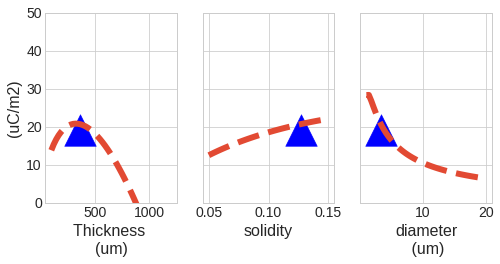

In [24]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.facecolor'] = 'none'


fig, ax = plt.subplots(1,3, figsize=(8,3.5), sharey=True)


#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u
h = set_h

J =  (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[0].plot(x*pow(10,6), J*pow(10,6), linestyle="--", linewidth = 6)
ax[0].scatter(set_thickness*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[0].set_xlabel("Thickness \n(um)", fontsize=16)
ax[0].set_ylabel("(uC/m2)", fontsize=16)
ax[0].tick_params(axis = 'x', labelsize=14)
ax[0].tick_params(axis = 'y', labelsize=14)
ax[0].set_ylim(0,50)



#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.15)
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


ax[1].plot(y,J*pow(10,6), linestyle="--", linewidth = 6)
ax[1].scatter(set_solidity, set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[1].set_xlabel("solidity", fontsize=16)

ax[1].tick_params(axis = 'x', labelsize=14)
ax[1].tick_params(axis = 'y', labelsize=14)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(1, 20)*pow(10,-6)
u = set_u
h = set_h

J =  (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[2].plot(z*pow(10,6),J*pow(10,6), linestyle="--", linewidth = 6)
ax[2].scatter(set_diameter*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[2].set_xlabel("diameter\n (um)", fontsize=16)




ax[2].tick_params(axis = 'x', labelsize=14)
ax[2].tick_params(axis = 'y', labelsize=14)

In [25]:
simulation_df = pd.DataFrame()

#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


simulation_df['thickness (um)']=np.linspace(100, 1200)
simulation_df['charge (uC)_1']=J*pow(10,6)

#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.15)
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)




simulation_df['solidity']=y
simulation_df['charge (uC)_2']=J*pow(10,6)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(1, 20)*pow(10,-6)
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)



simulation_df['diameter (um)']=z*pow(10,6)
simulation_df['charge (uC)_3']=J*pow(10,6)

In [26]:
simulation_df.to_excel('simulation_df_PP.xlsx')

# Validation at different random seeds

In [27]:
def get_index(random_state, data):
  kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
  train_indexs = []
  test_indexs = []
  for train_index, test_index in kf.split(data):
      train_indexs.append(train_index)
      test_indexs.append(test_index)
  index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
  return index

In [28]:
def get_scores(n_fold, index, data):
  train_index = index.iloc[n_fold,0]
  test_index = index.iloc[n_fold,1]
  train, test = data.iloc[train_index], data.iloc[test_index]
  train_shape=train.shape
  test_shape=test.shape

  def func(X,a, w, c, m, n, p):
    x,y,z,u,h = X
    return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  x=train['thickness(m)'].to_numpy()
  y=train['solidity'].to_numpy()
  z=train['diameter(m)'].to_numpy()
  u=train['Interface(m)'].to_numpy()
  h=train['Absolute humidity (g/m3)'].to_numpy()
  j=train['ChargeDensity(C/m2)'].to_numpy()


  # initial guesses for a,b,c,m,n,p:
  p0 = 1E-6 , 0 ,1. , 1. , 1., 1.

   # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=500000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=500000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  # print(trf_result)
  # print(dog_result)
  
  # Validate 
  
  data_val = pd.concat([train, test])
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Absolute humidity (g/m3)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape_trf = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_trf_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_trf_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])

  return n_fold, train_shape, test_shape, mape_trf, mape_trf_train, mape_trf_test,a,w,c,m,n,p

In [29]:
max_random_sate = 200

In [30]:
random_states = []
n_folds = []
train_shapes = []
test_shapes = []

MAPEs = []
train_MAPEs = []
test_MAPEs = []

a_list = []
w_list = []
c_list = []
m_list = []
n_list = []
p_list = []



for random_state in range(max_random_sate):
  index = get_index(random_state, data)
  for n_fold in range(1):
    random_states.append(random_state)
    n_fold, train_shape, test_shape, MAPE, train_MAPE, test_MAPE,a,w,c,m,n,p = get_scores(n_fold, index, data)
    n_folds.append(n_fold)
    train_shapes.append(train_shape)
    test_shapes.append(test_shape)
    
    MAPEs.append(MAPE)
    train_MAPEs.append(train_MAPE)
    test_MAPEs.append(test_MAPE)
    a_list.append(a)
    w_list.append(w)
    c_list.append(c)
    m_list.append(m)
    n_list.append(n)
    p_list.append(p)


dogbox Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Met

In [31]:
summary = pd.DataFrame()
summary['random_state']=random_states
summary['n_fold']=n_folds
summary['train_shape'] = train_shapes
summary['test_shape'] = test_shapes

summary['MAPE'] = MAPEs
summary['train_MAPE'] = train_MAPEs
summary['test_MAPE'] = test_MAPEs

summary['a'] = a_list
summary['w'] = w_list
summary['c'] = c_list
summary['m'] = m_list
summary['n'] = n_list
summary['p'] = p_list

summary

,random_state,n_fold,train_shape,test_shape,MAPE,train_MAPE,test_MAPE,a,w,c,m,n,p
0,0,0,"(13, 8)","(4, 8)",6.900375,7.562643,4.748001,0.054181,1.044228e-04,2.000030,1.000005,1.000014,1.000007
1,1,0,"(13, 8)","(4, 8)",8.638143,8.356167,9.554563,0.000008,3.460137e-07,1.059867,1.015167,1.147234,1.128599
2,2,0,"(13, 8)","(4, 8)",9.470695,8.945709,11.176899,0.000009,4.159008e-07,1.019819,1.029585,1.092655,1.103716
3,3,0,"(13, 8)","(4, 8)",8.991758,7.370201,14.261821,0.000004,8.566491e-09,1.121740,1.111948,1.187098,1.162889
4,4,0,"(13, 8)","(4, 8)",9.187003,6.651124,17.428612,0.000007,2.413224e-07,1.033204,1.044572,1.079202,1.096278
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0,"(13, 8)","(4, 8)",6.916837,5.218206,12.437386,0.000030,2.934443e-25,2.108194,1.010927,1.028317,1.013288
196,196,0,"(13, 8)","(4, 8)",9.234436,7.601013,14.543059,0.000008,3.103502e-07,1.037847,1.041342,1.077699,1.094982
197,197,0,"(13, 8)","(4, 8)",7.510194,6.953292,9.320124,0.000057,9.957489e-23,2.092268,1.008705,1.016173,1.006864
198,198,0,"(13, 8)","(4, 8)",8.855032,7.556109,13.076532,0.000006,2.270134e-07,1.036019,1.067212,1.112316,1.117609


In [32]:
summary.describe()

,random_state,n_fold,MAPE,train_MAPE,test_MAPE,a,w,c,m,n,p
count,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.000000
mean,99.500000,0.0,8.149360,7.472203,10.350122,0.000287,7.552315e-07,1.821265,1.036037,1.126426,1.099898
std,57.879185,0.0,1.023668,1.210411,3.424707,0.003830,7.377002e-06,4.993288,0.076781,0.124001,0.075642
min,0.000000,0.0,6.278459,3.452675,3.311678,0.000001,0.000000e+00,0.996542,0.975322,1.000014,1.000007
25%,49.750000,0.0,7.289114,6.787492,8.257088,0.000005,8.085912e-11,1.041665,1.008504,1.033004,1.017021
50%,99.500000,0.0,8.312105,7.581828,10.279670,0.000008,1.416242e-07,1.093901,1.015563,1.118550,1.109484
75%,149.250000,0.0,8.814704,8.323525,12.506152,0.000022,3.491284e-07,2.094362,1.053495,1.163280,1.134864
max,199.000000,0.0,11.081226,10.396343,23.963428,0.054181,1.044228e-04,71.676716,1.969068,2.396523,1.680794


In [33]:
summary.to_csv('100RandomState_PP.csv')

Text(0, 0.5, 'p')

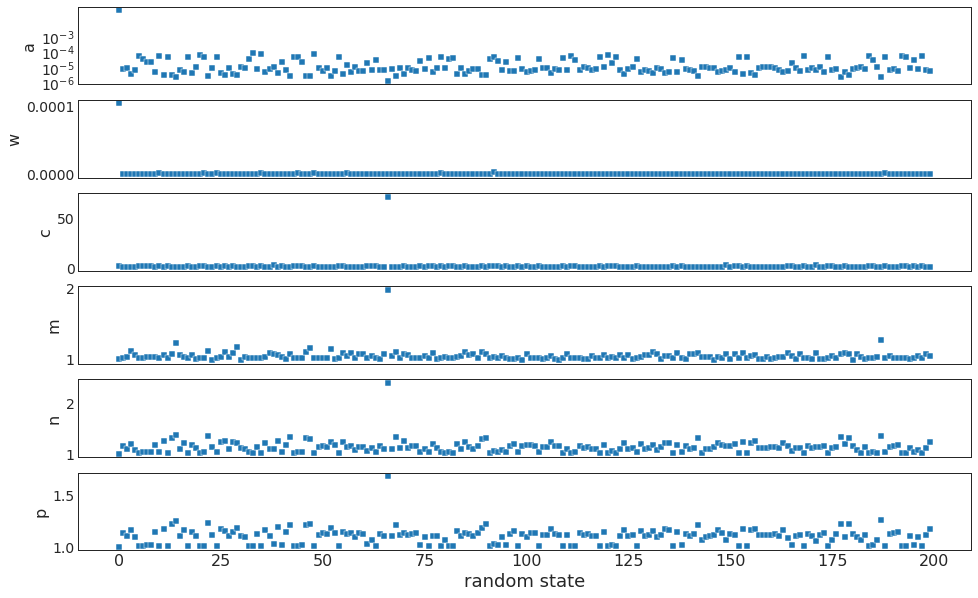

In [34]:
sns.set_style('white')
fig, ax = plt.subplots(6,1, figsize=(16,10), sharex=True)

sns.scatterplot(ax=ax[0], data=summary, x="random_state", y="a", marker = 's', color = 'tab:blue')
ax[0].set_yscale('log')
ax[0].set_yticks(np.logspace(-6, -3, 10))
ax[0].tick_params(axis = 'y', labelsize=14)
ax[0].set_ylabel("a", fontsize=16)

sns.scatterplot(ax=ax[1], data=summary, x="random_state", y="w", marker = 's', color = 'tab:blue')
ax[1].ticklabel_format(axis='y', style="sci")
ax[1].tick_params(axis = 'y', labelsize=14)
ax[1].set_ylabel("w", fontsize=16)

sns.scatterplot(ax=ax[2], data=summary, x="random_state", y="c", marker = 's', color = 'tab:blue')
ax[2].tick_params(axis = 'x', labelsize=16)
ax[2].tick_params(axis = 'y', labelsize=14)
ax[2].set_ylabel("c", fontsize=16)

sns.scatterplot(ax=ax[3], data=summary, x="random_state", y="m", marker = 's', color = 'tab:blue')
ax[3].tick_params(axis = 'x', labelsize=16)
ax[3].tick_params(axis = 'y', labelsize=14)
ax[3].set_ylabel("m", fontsize=16)


sns.scatterplot(ax=ax[4], data=summary, x="random_state", y="n", marker = 's', color = 'tab:blue')
ax[4].tick_params(axis = 'x', labelsize=16)
ax[4].tick_params(axis = 'y', labelsize=14)
ax[4].set_xlabel("random state", fontsize=16)
ax[4].set_ylabel("n", fontsize=16)


sns.scatterplot(ax=ax[5], data=summary, x="random_state", y="p", marker = 's', color = 'tab:blue')
ax[5].tick_params(axis = 'x', labelsize=16)
ax[5].tick_params(axis = 'y', labelsize=14)
ax[5].set_xlabel("random state", fontsize=18)
ax[5].set_ylabel("p", fontsize=16)

In [35]:
ax[0].set_yticks(np.logspace(-6, -3, 10))